# eXtreme Gradient Boosting (XGBoost) - Insurance Cost Prediction
## Import Libaries and Load Training Data

In [11]:
import pandas as pd
import scipy as sp
import numpy as np

# model and evaluation tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# data visualisation
import matplotlib.pyplot as plt

# explainability
import shap

## Data Preparation

In [24]:
# Load the cleaned dataset
df = pd.read_csv("Cleaned_Insurance.csv")

# Add additional variables
df['smoker_bmi'] = df['smoker_encoded'] * df['bmi']
df['smoker_age'] = df['smoker_encoded'] * df['age']

# Define features (X) and target (y)
X = df[['age', 'sex_encoded', 'bmi', 'children', 'smoker_encoded', 'region_encoded', 'smoker_bmi', 'smoker_age']]
y = df['charges_log'] 

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Initial Model - Baseline XGBRegressor

In [13]:
# Initialise a basic XGBoost regressor
xgb = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

## Evaluate Initial Model

In [14]:
# Evaluate initial model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}\nR2: {r2}\nMAE: {mae}")

RMSE: 0.44823887531132084
R2: 0.7835354381942105
MAE: 0.23113514923540204


## Tune Hyperparameters with GridSearchCV

In [15]:
grid = {
    "n_estimators": [25, 50, 75, 100],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 2, 3],
    "gamma": [0, 0.1, 0.2]
}

gs = GridSearchCV(
    estimator=xgb,
    param_grid=grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True
)

gs.fit(X_train, y_train)
print("\nTuned Hyperparameters by GridSearchCV")
for key, value in gs.best_params_.items():
    print(f"{key}: {value}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits

Tuned Hyperparameters by GridSearchCV
colsample_bytree: 0.8
gamma: 0.2
learning_rate: 0.1
max_depth: 3
min_child_weight: 3
n_estimators: 100
subsample: 1.0


## Evaluate Final Tuned Model

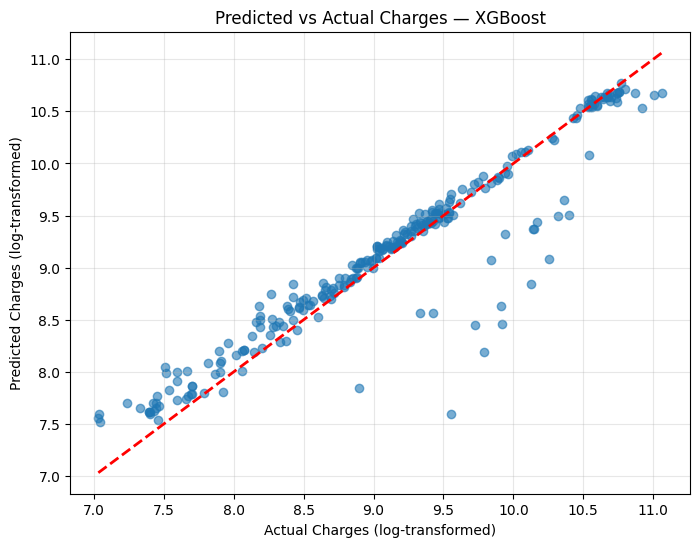

In [16]:
xgb_tuned = gs.best_estimator_
y_pred_tuned = xgb_tuned.predict(X_test)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_1 = r2_score(y_test, y_pred_tuned)
mae_1 = mean_absolute_error(y_test, y_pred_tuned)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Charges (log-transformed)")
plt.ylabel("Predicted Charges (log-transformed)")
plt.title("Predicted vs Actual Charges — XGBoost")
plt.grid(True, alpha=0.3)
plt.show()

**Interpretation**  
Majority of points cluster around the line of prediction by XGBoost, indicating strong agreement between predicted and actual *charges_log*.

## Evaluate Final Tuned Model Against Initial Model

In [17]:
results = pd.DataFrame({
    'Metric': ['RMSE', 'R2', 'MAE'],
    'Initial Model': [rmse, r2, mae],
    'Tuned Model': [rmse1, r2_1, mae_1]
})
results

,Metric,Initial Model,Tuned Model
0,RMSE,0.448239,0.327477
1,R2,0.783535,0.884461
2,MAE,0.231135,0.183333


The table shows significant improvements in RMSE (decrease), R2 (increase), and MAE (decrease), indicating the hyperparameter tuning by GridSearchCV from the initial model to tuned model was effective.

## Evaluate Tuned Model Performance against Train and Test Data Sets

In [18]:
y_pred_tuned_train = xgb_tuned.predict(X_train)
train_rmse1 = np.sqrt(mean_squared_error(y_train, y_pred_tuned_train))
train_r2_1 = r2_score(y_train, y_pred_tuned_train)
train_mae_1 = mean_absolute_error(y_train, y_pred_tuned_train)

performance = pd.DataFrame({
    'Metric': ['RMSE', 'R2', 'MAE'],
    'Train Value': [train_rmse1, train_r2_1, train_mae_1],
    'Test Value': [rmse1, r2_1, mae_1]
})
performance

,Metric,Train Value,Test Value
0,RMSE,0.350303,0.327477
1,R2,0.850673,0.884461
2,MAE,0.181422,0.183333


Generally, the tuned model performs slightly better on unseen test data than train data across all metrics (RMSE, R2, MAE), indicating that the model is likely not overfit and generalises well to unseen data.

## Feature Importance by SHapley Additive exPlanations (SHAP)

SHAP is used to explain how a machine learning model makes decisions. It assigns a value to every single feature for every single prediction, which represents the feature's contribution to pushing the prediction away from the average.

While XGBoost is a powerful technique, it is also a black-box. As such, we chose to use SHAP to achieve greater interpretability and explainability of the tuned model's predictions.

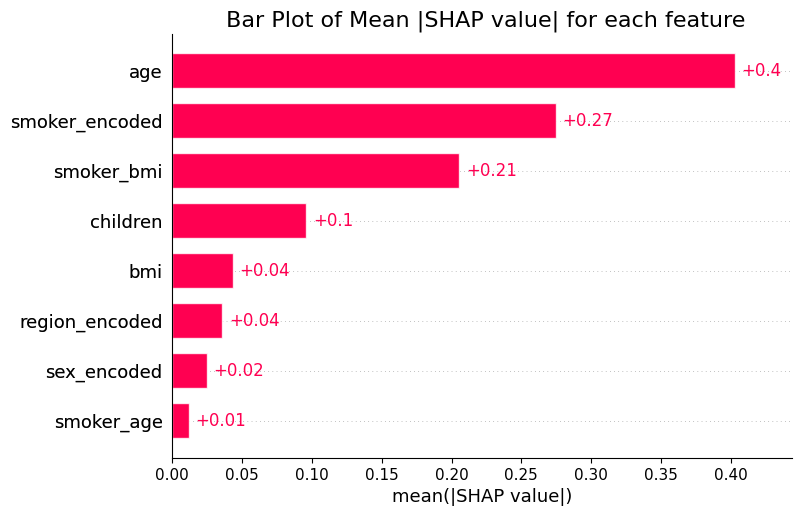

In [19]:
explainer = shap.Explainer(xgb_tuned.predict, X_train)
shap_values = explainer(X_train)

plt.title(" Bar Plot of Mean |SHAP value| for each feature", size=16)
shap.plots.bar(shap_values.abs.mean(0))

The Bar Plot of Mean |SHAP value| ranks the model's features by their average absolute impact on the model's outpet.

The features *age* and *smoker_encoded* are the most important features and act as primary drivers for predicting insurance cost in the model.
Meanwhile *smoker_bmi* and *children* are moderately important.
Features like *bmi*, *region_encoded*, *sex_encoded*, and *smoker_age* have a relatively small impact on the model.

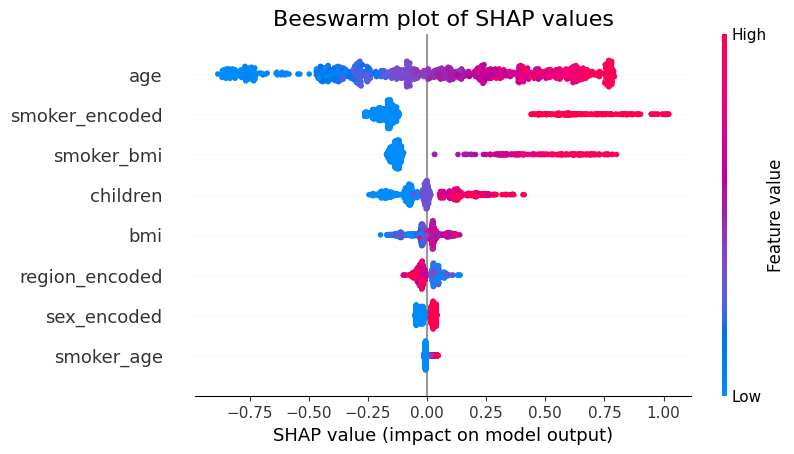

In [20]:
plt.title("Beeswarm plot of SHAP values", size=16)
shap.plots.beeswarm(shap_values)

Meanwhile, the Beeswarm plot of SHAP values shows the distribution of SHAP values for each feature across the given dataset, plotting both direction and value of the feature on insurance cost outcomes.

**age**  
The plot shows a clear positive linear relationship between *age* and *charges_log*.

**smoker_encoded**  
Being a smoker (smoker_encoded=1) leads to very high positive SHAP values, while not smoking (smoker_encoded=0) pushes *charges_log* down or has a more neutral effect. This demonstrates that smoking statis is a binary trigger for a massive increase in predicted insurance cost.

**smoker_bmi**  
SHAP values are similarly distributed in *smoker_bmi* and *smoker_encoded*, indicating that BMI is more important for a smoker's insurance cost than BMI is alone, and the interaction between the two terms is significant on the model.

**children**  
The plot shows a moderate positive linear relationship between *children* and *charges_log*.

**bmi, region_encoded, sex_encoded, smoker_age**  
These features are clustered tightly around the 0.0 SHAP value, confirming that they have little influence on predicted insurance cost for most individuals.

This could indicate greater fairness and reduced bias in the model. Minimising reliance on such features promotes non-discriminatory outcomes.

## Fairness Analysis

In [50]:
results = X_test.copy()
results['y_test'] = y_test
results['y_pred'] = y_pred_tuned
results['residual'] = results['y_test'] - results['y_pred']

def group_error_metrics(df, group_col, dict):
    group_stats = []
    for val, subset in df.groupby(group_col):
        rmse = np.sqrt(mean_squared_error(subset['y_test'], subset['y_pred']))
        mae = mean_absolute_error(subset['y_test'], subset['y_pred'])
        mean_resid = subset['residual'].mean()
        group_stats.append({
            'Group': dict[val],
            'Value': val,
            'Count': len(subset),
            'Mean Residual': mean_resid,
            'RMSE': rmse,
            'MAE': mae
        })
    return pd.DataFrame(group_stats)

sex = {0: 'female', 1: 'male'}
metrics_sex = group_error_metrics(results, 'sex_encoded', sex)
metrics_sex

,Group,Value,Count,Mean Residual,RMSE,MAE
0,female,0,125,-0.036467,0.295790,0.183597
1,male,1,143,0.005387,0.352853,0.183102


**sex**  
Calculating mean residual, RMSE, and MAE of predictions by the tuned model by group, the mean residual and MAE are relatively similar. RMSE has a slight difference between the two groups.

In [51]:
region = {
    0: 'northwest',
    1: 'northeast',
    2: 'southeast',
    3: 'southwest'
}
metrics_region = group_error_metrics(results, 'region_encoded', region)
metrics_region

,Group,Value,Count,Mean Residual,RMSE,MAE
0,northwest,0,60,-0.049740,0.248379,0.151918
1,northeast,1,71,0.092564,0.427750,0.224416
2,southeast,2,77,-0.052815,0.342778,0.207866
3,southwest,3,60,-0.055148,0.223647,0.134648


**region**  
There are significant differences in RMSE and slight differences in mean residual and MAE across the four regions.